In [5]:
import gymnasium as gym
import cookiedisaster
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from BaseAgent import AbstractAgent
print(torch.__version__)

SEED=2
np.random.seed(SEED)
random.seed(SEED)

2.2.2


In [14]:
# actor critic model
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.fc(x)

class ValueNetwork(nn.Module):
    def __init__(self, input_dim):
        super(ValueNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.fc(x)

# important parameters that need to be updated based on the environment
ENV_WIDTH=0.001
ENV_LIFETIME=1
MAX_TIME=ENV_LIFETIME*10*5 # 10 cookies elapse time (lifetime*steps_per_second*nr_of_elapsed_cookies)

def normalize(value, min_value, max_value, scale_min=-1, scale_max=1):
    return ((value - min_value) / (max_value - min_value)) * (scale_max - scale_min) + scale_min

def preprocess_state(state):
    # Assuming state is a dictionary like:
    # {'robot': {'pos': x, 'vel': y}, 'cookie': {'pos': z, 'time': w}}
    
    robot_pos = normalize(state['agent']['pos'], 0, ENV_WIDTH)
    robot_vel = normalize(state['agent']['vel'], -4, 4)
    cookie_pos = normalize(state['cookie']['pos'], 0, ENV_WIDTH)
    cookie_time = normalize(state['cookie']['time'], 0, ENV_LIFETIME)
    distance = robot_pos - cookie_pos
    direction = 1 if distance > 0 else -1
    
    # Return the normalized state as a numpy array
    return np.array([robot_pos, robot_vel, cookie_pos, cookie_time,distance, direction])

def update_env(state):
    global ENV_WIDTH,ENV_LIFETIME,MAX_TIME
    ENV_WIDTH=state['agent']['pos']*2
    ENV_LIFETIME=state['cookie']['time']
    MAX_TIME=ENV_LIFETIME*10*5 

class CookiePatrolAgent(AbstractAgent):
    def __init__(self, input_dim, output_dim,epsilon=0, lr=0.001,save_path=None):
        super().__init__()
        self.policy = PolicyNetwork(input_dim, output_dim)
        self.value = ValueNetwork(input_dim)
        self.epsilon = epsilon
        self.count=0
        if save_path:
            self.load(save_path)
        else:
            self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=lr)
            self.value_optimizer = optim.Adam(self.value.parameters(), lr=lr)

    def select_action(self, observation):
        if self.count==0:
            print('First observation:',observation)
            update_env(observation)
            self.count+=1
        observation=preprocess_state(observation)
        state_tensor = torch.FloatTensor(observation).unsqueeze(0)
        action_probs = self.policy(state_tensor)
        distribution = torch.distributions.Categorical(action_probs)
        action = distribution.sample()
        self.log_prob = distribution.log_prob(action)
        if np.random.rand() < self.epsilon:
            return np.random.choice([0, 1, 2])
        return action.item()

    def learn(self, state, reward, next_state, done):
        state=preprocess_state(state)
        next_state=preprocess_state(next_state)
        state_value = self.value(torch.FloatTensor(state).unsqueeze(0))
        next_state_value = self.value(torch.FloatTensor(next_state).unsqueeze(0))
        td_target = reward + (0.99 * next_state_value * (1 - int(done)))
        td_error = td_target - state_value
        
        # Critic loss
        critic_loss = td_error.pow(2)
        self.value_optimizer.zero_grad()
        critic_loss.backward()
        self.value_optimizer.step()

        # Actor loss
        actor_loss = -self.log_prob * td_error.detach()
        self.policy_optimizer.zero_grad()
        actor_loss.backward()
        self.policy_optimizer.step()

        # update epsilon if the agent is learning
        if self.epsilon!=0:
            self.epsilon = max(0.01, self.epsilon * 0.995)
        

    def save(self, path):
        torch.save({'policy_state_dict': self.policy.state_dict(),
                    'value_state_dict': self.value.state_dict()}, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.policy.load_state_dict(checkpoint['policy_state_dict'])
        self.value.load_state_dict(checkpoint['value_state_dict'])

    #ask fabio can have extra functions here, or keep seperate from base agent??

    
# # Example of how to instantiate and use the agent
# env_parameters = {
#     'input_dim': 6,  # Adjust based on your environment observation space
#     'output_dim': 3  # Adjust based on your environment action space
# }
# agent = CookiePatrolAgent(**env_parameters)


In [8]:
def train_on_environments(envs, num_episodes_per_env=20, gamma=0.99):
    results = {}
    agent_parameters = {'input_dim': 6, 'output_dim': envs[0].action_space.n, 'epsilon':0.5}
    agent = CookiePatrolAgent(**agent_parameters)
    
    for i in range(len(envs)):
        env = envs[i]
        episode_rewards = []
        for episode in range(num_episodes_per_env):
            state = env.reset()[0]
            # print('state',state)
            update_env(state)
            # state = preprocess_state(state)
            done = False
            total_reward = 0
            count = 0
            while not done:
                if count > MAX_TIME:
                    # print('time out')
                    break
                count+=1
                action = agent.select_action(state)
                next_state, reward, done, _, _ = env.step(action)
                # print('next_state',next_state)
                # next_state = preprocess_state(next_state)

                agent.learn(state, reward, next_state, done)
                state = next_state
                total_reward += reward

            episode_rewards.append(total_reward)
            # print('ep,end')
            if episode % 10 == 0:
                print(f"Environment {i}: Episode {episode} Reward: {total_reward}")
        
        results[i] = episode_rewards
    return results, agent


envs = [
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 10, "lifetime":5, "friction": lambda vel: - abs(vel)*vel * 0.05}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 10, "lifetime":5, "friction": lambda vel: - abs(vel)*vel * 0.08}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 10, "lifetime":5, "friction": lambda vel: - abs(vel)*vel * 0.01}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 10, "lifetime":4, "friction": lambda vel: - abs(vel)*vel * 0.05}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 10, "lifetime":4, "friction": lambda vel: - abs(vel)*vel * 0.08}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 10, "lifetime":4, "friction": lambda vel: - abs(vel)*vel * 0.01}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 10, "lifetime":7, "friction": lambda vel: - abs(vel)*vel * 0.05}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 10, "lifetime":7, "friction": lambda vel: - abs(vel)*vel * 0.08}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 10, "lifetime":7, "friction": lambda vel: - abs(vel)*vel * 0.01}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 5, "lifetime":5, "friction": lambda vel: - abs(vel)*vel * 0.05}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 5, "lifetime":5, "friction": lambda vel: - abs(vel)*vel * 0.08}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 5, "lifetime":5, "friction": lambda vel: - abs(vel)*vel * 0.01}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 5, "lifetime":4, "friction": lambda vel: - abs(vel)*vel * 0.05}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 5, "lifetime":4, "friction": lambda vel: - abs(vel)*vel * 0.08}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 5, "lifetime":4, "friction": lambda vel: - abs(vel)*vel * 0.01}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 5, "lifetime":7, "friction": lambda vel: - abs(vel)*vel * 0.05}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 5, "lifetime":7, "friction": lambda vel: - abs(vel)*vel * 0.08}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 5, "lifetime":7, "friction": lambda vel: - abs(vel)*vel * 0.01}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 12, "lifetime":5, "friction": lambda vel: - abs(vel)*vel * 0.05}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 12, "lifetime":5, "friction": lambda vel: - abs(vel)*vel * 0.08}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 12, "lifetime":5, "friction": lambda vel: - abs(vel)*vel * 0.01}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 12, "lifetime":4, "friction": lambda vel: - abs(vel)*vel * 0.05}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 12, "lifetime":4, "friction": lambda vel: - abs(vel)*vel * 0.08}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 12, "lifetime":4, "friction": lambda vel: - abs(vel)*vel * 0.01}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 12, "lifetime":7, "friction": lambda vel: - abs(vel)*vel * 0.05}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 12, "lifetime":7, "friction": lambda vel: - abs(vel)*vel * 0.08}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 12, "lifetime":7, "friction": lambda vel: - abs(vel)*vel * 0.01}),
]
random.shuffle(envs)
all_env_results,agent = train_on_environments(envs, num_episodes_per_env=5)

# Optionally, print or plot the results for each environment
for env_name, rewards in all_env_results.items():
    print(f"Results for {env_name}: Average Reward: {sum(rewards) / len(rewards)}")


c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment cookiedisaster-v1 is out of date. You should consider upgrading to version `v3`.
  logger.deprecation(


Environment 0: Episode 0 Reward: -11.801055209464124
Environment 1: Episode 0 Reward: 7.718166117584107
Environment 2: Episode 0 Reward: 14.804839355317469
Environment 3: Episode 0 Reward: 46.820693851226984
Environment 4: Episode 0 Reward: 24
Environment 5: Episode 0 Reward: 24.940470097647033
Environment 6: Episode 0 Reward: 20.75468031359724
Environment 7: Episode 0 Reward: 34.91452321102804
Environment 8: Episode 0 Reward: 31.308884927014972
Environment 9: Episode 0 Reward: 55.949907516836994
Environment 10: Episode 0 Reward: 23
Environment 11: Episode 0 Reward: 23
Environment 12: Episode 0 Reward: 28.100056309131737
Environment 13: Episode 0 Reward: 26
Environment 14: Episode 0 Reward: 38.83841505746278
Environment 15: Episode 0 Reward: 32.218962717288974
Environment 16: Episode 0 Reward: 12.5
Environment 17: Episode 0 Reward: 37.07325905427789
Environment 18: Episode 0 Reward: 38.55546519909471
Environment 19: Episode 0 Reward: 44.32343253316225
Environment 20: Episode 0 Reward: 

In [9]:
# envs = [
#     gym.make('cookiedisaster-v1',config={"img": "cake","width" : 10, "lifetime":5, "friction": lambda vel: - abs(vel)*vel * 0.05}),
#     gym.make('cookiedisaster-v1',config={"img": "cake","width" : 10, "lifetime":5, "friction": lambda vel: - abs(vel)*vel * 0.08}),
#     gym.make('cookiedisaster-v1',config={"img": "cake","width" : 10, "lifetime":5, "friction": lambda vel: - abs(vel)*vel * 0.01}),
#     gym.make('cookiedisaster-v1',config={"img": "cake","width" : 10, "lifetime":4, "friction": lambda vel: - abs(vel)*vel * 0.05}),
#     gym.make('cookiedisaster-v1',config={"img": "cake","width" : 10, "lifetime":4, "friction": lambda vel: - abs(vel)*vel * 0.08}),
#     gym.make('cookiedisaster-v1',config={"img": "cake","width" : 10, "lifetime":4, "friction": lambda vel: - abs(vel)*vel * 0.01}),
#     gym.make('cookiedisaster-v1',config={"img": "cake","width" : 10, "lifetime":7, "friction": lambda vel: - abs(vel)*vel * 0.05}),
#     gym.make('cookiedisaster-v1',config={"img": "cake","width" : 10, "lifetime":7, "friction": lambda vel: - abs(vel)*vel * 0.08}),
#     gym.make('cookiedisaster-v1',config={"img": "cake","width" : 10, "lifetime":7, "friction": lambda vel: - abs(vel)*vel * 0.01}),
#     gym.make('cookiedisaster-v1',config={"img": "cake","width" : 5, "lifetime":5, "friction": lambda vel: - abs(vel)*vel * 0.05}),
#     gym.make('cookiedisaster-v1',config={"img": "cake","width" : 5, "lifetime":5, "friction": lambda vel: - abs(vel)*vel * 0.08}),
#     gym.make('cookiedisaster-v1',config={"img": "cake","width" : 5, "lifetime":5, "friction": lambda vel: - abs(vel)*vel * 0.01}),
#     gym.make('cookiedisaster-v1',config={"img": "cake","width" : 5, "lifetime":4, "friction": lambda vel: - abs(vel)*vel * 0.05}),
#     gym.make('cookiedisaster-v1',config={"img": "cake","width" : 5, "lifetime":4, "friction": lambda vel: - abs(vel)*vel * 0.08}),
#     gym.make('cookiedisaster-v1',config={"img": "cake","width" : 5, "lifetime":4, "friction": lambda vel: - abs(vel)*vel * 0.01}),
#     gym.make('cookiedisaster-v1',config={"img": "cake","width" : 5, "lifetime":7, "friction": lambda vel: - abs(vel)*vel * 0.05}),
#     gym.make('cookiedisaster-v1',config={"img": "cake","width" : 5, "lifetime":7, "friction": lambda vel: - abs(vel)*vel * 0.08}),
#     gym.make('cookiedisaster-v1',config={"img": "cake","width" : 5, "lifetime":7, "friction": lambda vel: - abs(vel)*vel * 0.01}),
#     gym.make('cookiedisaster-v1',config={"img": "cake","width" : 12, "lifetime":5, "friction": lambda vel: - abs(vel)*vel * 0.05}),
#     gym.make('cookiedisaster-v1',config={"img": "cake","width" : 12, "lifetime":5, "friction": lambda vel: - abs(vel)*vel * 0.08}),
#     gym.make('cookiedisaster-v1',config={"img": "cake","width" : 12, "lifetime":5, "friction": lambda vel: - abs(vel)*vel * 0.01}),
#     gym.make('cookiedisaster-v1',config={"img": "cake","width" : 12, "lifetime":4, "friction": lambda vel: - abs(vel)*vel * 0.05}),
#     gym.make('cookiedisaster-v1',config={"img": "cake","width" : 12, "lifetime":4, "friction": lambda vel: - abs(vel)*vel * 0.08}),
#     gym.make('cookiedisaster-v1',config={"img": "cake","width" : 12, "lifetime":4, "friction": lambda vel: - abs(vel)*vel * 0.01}),
#     gym.make('cookiedisaster-v1',config={"img": "cake","width" : 12, "lifetime":7, "friction": lambda vel: - abs(vel)*vel * 0.05}),
#     gym.make('cookiedisaster-v1',config={"img": "cake","width" : 12, "lifetime":7, "friction": lambda vel: - abs(vel)*vel * 0.08}),
#     gym.make('cookiedisaster-v1',config={"img": "cake","width" : 12, "lifetime":7, "friction": lambda vel: - abs(vel)*vel * 0.01}),
# ]
# random.shuffle(envs)
# envs[0].spec.kwargs['config'],envs[1].spec.kwargs['config'],envs[2].spec.kwargs['config']

In [10]:
# plt.plot(all_env_results[cookie_1.spec.id], label='Cookie Disaster v1')
# plt.plot(all_env_results[cookie_2.spec.id], label='Cookie Disaster v2')
# plt.plot(all_env_results[cookie_3.spec.id], label='Cookie Disaster v3')
# plt.xlabel('Episode')
# plt.ylabel('Total Reward')
# plt.title('Cumulative Reward vs. Episodes')
# plt.legend()
# plt.show()

In [12]:
def test_agent(agent, env, num_episodes=500):
    rewards = []
    state = env.reset()[0]
    update_env(state)
    # state = preprocess_state(state)
    total_reward = 0
    for _ in range(num_episodes):
        action = agent.select_action(state)
        next_state, reward, done, _, _ = env.step(action)
        # next_state = preprocess_state(next_state)
        state = next_state
        total_reward += reward
        rewards.append(total_reward)
    env.close()
    return rewards


cookie_1 = gym.make('cookiedisaster-v1')  
cookie_2 = gym.make('cookiedisaster-v2')
cookie_3 = gym.make('cookiedisaster-v3')
rewards=[]
envs = [cookie_1, cookie_2, cookie_3]
for env in envs:
    rewards.append(test_agent(agent, env))
    print(f"Results for {env.spec.id}: Average Reward: {sum(rewards[-1]) / len(rewards[-1])}")


Results for cookiedisaster-v1: Average Reward: 26.458581633509965
Results for cookiedisaster-v2: Average Reward: 45.86141702566411
Results for cookiedisaster-v3: Average Reward: 27.914006466054364


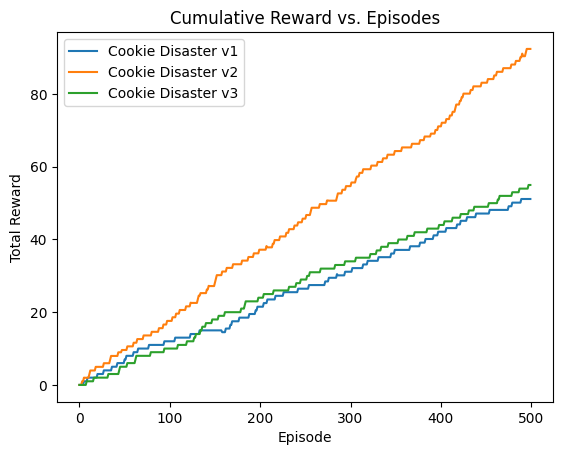

In [13]:
plt.plot(rewards[0], label='Cookie Disaster v1')
plt.plot(rewards[1], label='Cookie Disaster v2')
plt.plot(rewards[2], label='Cookie Disaster v3')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Cumulative Reward vs. Episodes')
plt.legend()
plt.show()

In [24]:
env=gym.make('cookiedisaster-v1',config={"img": "cake","width" : 100, "lifetime":8, "friction": lambda vel: - abs(vel)*vel * 0.1},render_mode='human')

In [25]:
test_agent(agent,env)

KeyboardInterrupt: 

In [ ]:
env.render()

In [17]:
env.close()

In [ ]:
env.step(0)

({'agent': {'pos': 1e-05, 'vel': 0.0},
  'cookie': {'pos': 1.45531695765728, 'time': 6}},
 -0.6,
 False,
 False,
 {'distance': 1.45530695765728, 'steps': 34})

In [ ]:
normalize(0,0,10)

-1.0

In [ ]:
normalize(5,-4,4)

1.25